# Data Career Navigator: EDA on Enriched Jobs Dataset

This notebook follows a step-by-step roadmap for profiling, cleaning, and analyzing `enriched_jobs.csv`.

---

## Step 1: Load & Profile

We load the data, inspect its structure, and document missingness. Decisions on handling missing values are also recorded.

In [125]:
# Step 1: Load & Profile
import pandas as pd
import numpy as np

def profile_df(df):
    print("\n--- DataFrame Info ---")
    df.info()
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
    print("\n--- Sample Rows ---")
    display(df.head())

# Load the data
df = pd.read_csv('../data/silver/enriched_jobs.csv')
profile_df(df)


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     976 non-null    int64  
 1   title                  976 non-null    object 
 2   company                976 non-null    object 
 3   location               976 non-null    object 
 4   link                   976 non-null    object 
 5   source                 887 non-null    object 
 6   date_posted            953 non-null    object 
 7   work_type              976 non-null    object 
 8   employment_type        976 non-null    object 
 9   description            976 non-null    object 
 10  header_text            900 non-null    object 
 11  has_salary             976 non-null    bool   
 12  currency_raw           976 non-null    object 
 13  min_salary_raw         330 non-null    float64
 14  max_salary_raw         342 non-nul

,id,title,company,location,link,source,date_posted,work_type,employment_type,description,...,min_salary_annual_usd,max_salary_annual_usd,avg_salary_annual_usd,salary_confidence,experience_level,programming_languages,libraries,analyst_tools,cloud_platforms,country
0,1,Data Analyst,Meta,"New York, NY",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,Not Specified,Full-time,The Social Measurement team is a growing team ...,...,124000.0,176000.0,150000.0,0.9,Not Specified,python;r;sql,NaN,tableau,NaN,United States
1,2,Data Analyst,Meta,"San Francisco, CA",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,Not Specified,Full-time,The Social Measurement team is a growing team ...,...,124000.0,176000.0,150000.0,0.9,Not Specified,python;r;sql,NaN,tableau,NaN,United States
2,3,Data Analyst,Meta,"Los Angeles, CA",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,Not Specified,Full-time,The Social Measurement team is a growing team ...,...,124000.0,176000.0,150000.0,0.9,Not Specified,python;r;sql,NaN,tableau,NaN,United States
3,4,Data Analyst,Meta,"Washington, DC",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,Not Specified,Full-time,The Social Measurement team is a growing team ...,...,124000.0,176000.0,150000.0,0.9,Not Specified,python;r;sql,NaN,tableau,NaN,United States
4,5,Data Analyst II,Pinterest,"Chicago, IL",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-16,Hybrid,Full-time,About Pinterest\r\n\r\nMillions of people arou...,...,NaN,NaN,NaN,NaN,Not Specified,python;sql,NaN,NaN,NaN,United States


### Columns to Analyze & Missing Data Strategy

- **Columns for analysis:**
    - Dates: `date_posted`
    - Salary: `min_salary_annual_usd`, `max_salary_annual_usd`, `avg_salary_annual_usd`
    - Experience: `experience_level`
    - Skills: `programming_languages`, `libraries`, `analyst_tools`, `cloud_platforms`
    - Location, Work Type, Source
- **Missing Data Handling:**
    - `date_posted`: Fill missing as "Unknown" (string) for grouping/filtering.
    - Salary fields: For salary analyses, group missing as "Not disclosed"; for modeling, consider dropping or imputing.
    - Other fields: Leave as-is unless critical for analysis.

---

## Step 2: Clean & Transform Key Fields

We clean and transform date, salary, experience, and skill columns for analysis.

In [126]:
# Step 2: Clean & Transform Key Fields

def clean_dates(df):
    df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
    df['date_posted_filled'] = df['date_posted'].fillna('Unknown')
    return df

def clean_salary(df):
    for col in ['min_salary_annual_usd', 'max_salary_annual_usd', 'avg_salary_annual_usd']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['salary_disclosed'] = ~df['avg_salary_annual_usd'].isnull()
    df['salary_group'] = df['salary_disclosed'].map({True: 'Disclosed', False: 'Not disclosed'})
    return df

def check_experience_levels(df):
    print(df['experience_level'].value_counts(dropna=False))

skill_cols = ['programming_languages', 'libraries', 'analyst_tools', 'cloud_platforms']
def parse_skills(df, skill_cols):
    for col in skill_cols:
        df[col] = df[col].fillna('').apply(lambda x: [s.strip() for s in x.split(';') if s.strip()])
    return df

# Apply cleaning functions
df = clean_dates(df)
df = clean_salary(df)
check_experience_levels(df)
df = parse_skills(df, skill_cols)

experience_level
Not Specified    766
Senior           113
Entry-Level       89
Mid-Level          8
Name: count, dtype: int64


- **Dates:** Converted to datetime, missing flagged as "Unknown".
- **Salary:** Numeric conversion, missing grouped as "Not disclosed".
- **Experience:** Checked for typos or unexpected values.
- **Skills:** Parsed into Python lists for analysis.

---

_Next: Univariate analyses of experience, salary, and skills._

---

## Step 3: Univariate Analyses

We analyze the distribution of experience levels, salary, and top skills in the dataset.

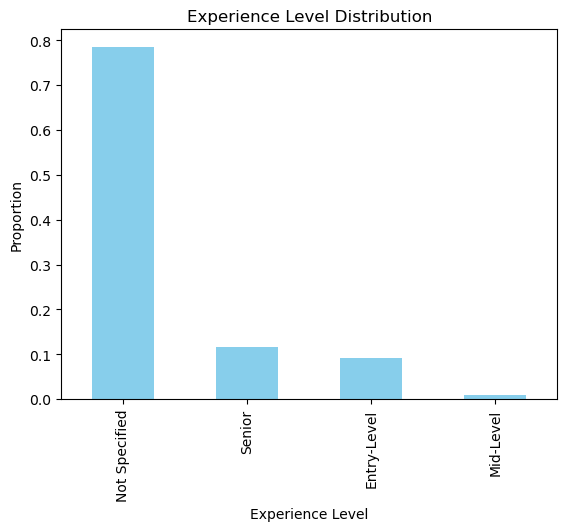

experience_level
Not Specified    0.784836
Senior           0.115779
Entry-Level      0.091189
Mid-Level        0.008197
Name: proportion, dtype: float64


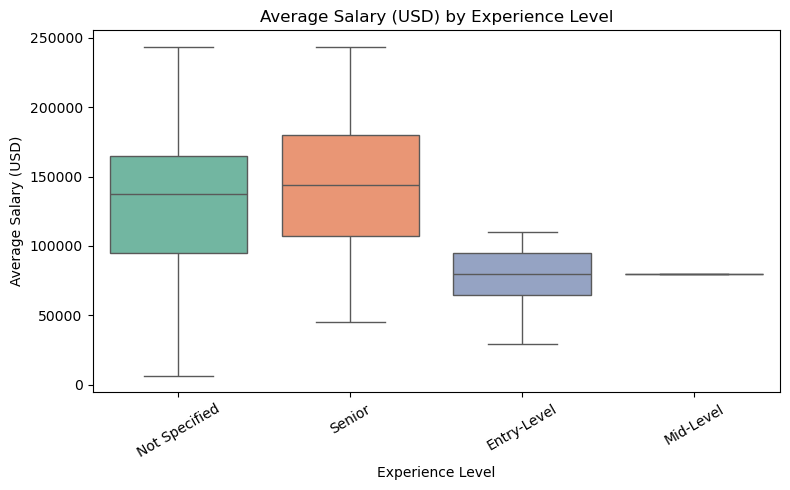

In [127]:
# Experience Level Distribution

def plot_experience_distribution(df):
    import matplotlib.pyplot as plt
    vc = df['experience_level'].value_counts(normalize=True)
    ax = vc.plot(kind='bar', color='skyblue')
    plt.title('Experience Level Distribution')
    plt.ylabel('Proportion')
    plt.xlabel('Experience Level')
    plt.show()
    print(vc)

plot_experience_distribution(df)

# Salary vs. Experience Level
import matplotlib.pyplot as plt
import seaborn as sns

def plot_salary_vs_experience(df):
    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='experience_level',
        y='avg_salary_annual_usd',
        data=df,
        hue='experience_level',
        showfliers=False,
        palette='Set2',
        legend=False
    )
    plt.title('Average Salary (USD) by Experience Level')
    plt.xlabel('Experience Level')
    plt.ylabel('Average Salary (USD)')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

plot_salary_vs_experience(df)

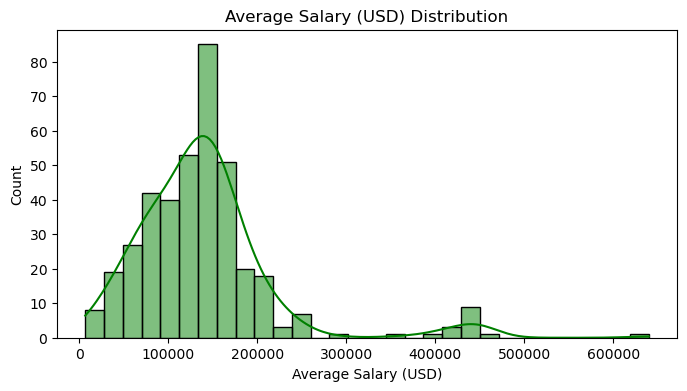

Outliers above 306,675 USD: 16


In [128]:
# Salary Distribution: Histogram and Outlier Detection

def plot_salary_distribution(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    salaries = df['avg_salary_annual_usd'].dropna()
    plt.figure(figsize=(8,4))
    sns.histplot(salaries, bins=30, kde=True, color='green')
    plt.title('Average Salary (USD) Distribution')
    plt.xlabel('Average Salary (USD)')
    plt.ylabel('Count')
    plt.show()
    # Outlier detection (IQR method)
    Q1 = salaries.quantile(0.25)
    Q3 = salaries.quantile(0.75)
    IQR = Q3 - Q1
    outlier_thresh = Q3 + 2 * IQR
    n_outliers = (salaries > outlier_thresh).sum()
    print(f"Outliers above {outlier_thresh:,.0f} USD: {n_outliers}")

plot_salary_distribution(df)

In [129]:
# Top Skills by Category (Individual Skill Counts)

def top_skills_individual(df, skill_col, n=10):
    # Explode so each row is a single skill
    exploded = df.explode(skill_col)[skill_col]
    # Flatten lists to strings if needed
    exploded = exploded.apply(lambda x: x if isinstance(x, str) else (x if pd.isnull(x) else str(x)))
    # Remove empty strings and brackets
    exploded = exploded[exploded.notnull() & (exploded != '')]
    # If any values are still lists, flatten them
    import ast
    def flatten_skill(val):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
            else:
                return [val]
        except:
            return [val]
    all_skills = []
    for v in exploded:
        all_skills.extend(flatten_skill(v))
    all_skills = [s for s in all_skills if s and s != '']
    import collections
    vc = collections.Counter(all_skills)
    top = vc.most_common(n)
    print(f"Top {n} {skill_col.replace('_', ' ').title()}:")
    for skill, count in top:
        print(f"{skill}: {count}")
    return top

for col in skill_cols:
    top_skills_individual(df, col)

Top 10 Programming Languages:
sql: 683
python: 655
r: 245
scala: 99
c: 98
java: 81
go: 63
nosql: 39
sas: 37
javascript: 22
Top 10 Libraries:
spark: 177
scikit-learn: 44
jupyter: 18
keras: 17
node.js: 6
mxnet: 2
opencv: 1
nltk: 1
Top 10 Analyst Tools:
tableau: 256
excel: 202
azure: 149
snowflake: 106
looker: 97
airflow: 76
pytorch: 69
git: 63
pyspark: 63
hadoop: 62
Top 10 Cloud Platforms:
aws: 197
azure: 149
snowflake: 106
gcp: 76
redshift: 69
bigquery: 60
aurora: 5


- **Experience Level:** Distribution visualized and tabulated.
- **Salary:** Histogram plotted, outliers identified.
- **Skills:** Top skills by category listed.

---

_Next: Bivariate and multivariate analyses (salary vs. experience, skill co-occurrence, temporal trends)._

---

## Step 4: Bivariate & Multivariate Analyses

We explore relationships between salary and experience, skill co-occurrence, and temporal trends in job postings.

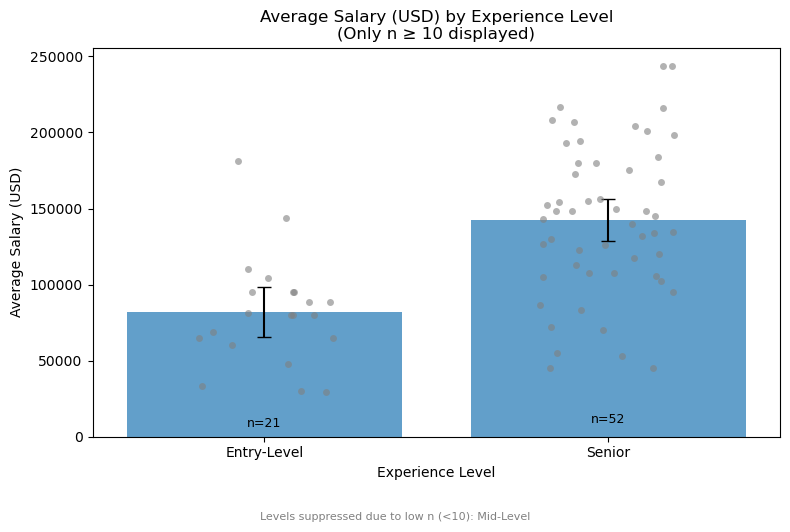

In [130]:
# Salary vs Experience
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Prepare salary column as numeric
df['avg_salary'] = pd.to_numeric(df['avg_salary_annual_usd'], errors='coerce')
df_sal = df.dropna(subset=['avg_salary'])

# Define experience levels of interest
levels_all = ['Entry-Level', 'Mid-Level', 'Senior']
counts = df_sal['experience_level'].value_counts()
threshold = 10
levels_to_plot = [lvl for lvl in levels_all if counts.get(lvl, 0) >= threshold]
suppressed = [lvl for lvl in levels_all if lvl not in levels_to_plot]

# Compute mean and 95% CI for each level
summary = (
    df_sal[df_sal['experience_level'].isin(levels_to_plot)]
    .groupby('experience_level')['avg_salary']
    .agg(['mean','count','std'])
)
summary['ci95'] = summary.apply(
    lambda r: stats.t.ppf(0.975, r['count']-1) * r['std'] / np.sqrt(r['count']),
    axis=1
)

plt.figure(figsize=(8,5))

# Bar chart of mean ± CI
plt.bar(
    x=summary.index,
    height=summary['mean'],
    yerr=summary['ci95'],
    capsize=5,
    alpha=0.7
)

# Overlay raw points
sns.stripplot(
    x='experience_level',
    y='avg_salary',
    data=df_sal[df_sal['experience_level'].isin(levels_to_plot)],
    order=levels_to_plot,
    jitter=0.2,
    size=5,
    color='gray',
    alpha=0.6
)

# Annotate sample sizes
for i, lvl in enumerate(levels_to_plot):
    n = int(summary.loc[lvl, 'count'])
    plt.text(i, summary.loc[lvl, 'mean']*0.05, f"n={n}", 
             ha='center', va='bottom', fontsize=9, color='black')

plt.title('Average Salary (USD) by Experience Level\n(Only n ≥ 10 displayed)')
plt.xlabel('Experience Level')
plt.ylabel('Average Salary (USD)')
plt.tight_layout()

# Footnote for suppressed levels
if suppressed:
    foot = f"Levels suppressed due to low n (<{threshold}): " + ', '.join(suppressed)
    plt.figtext(0.5, -0.05, foot, ha='center', fontsize=8, color='gray')

plt.show()

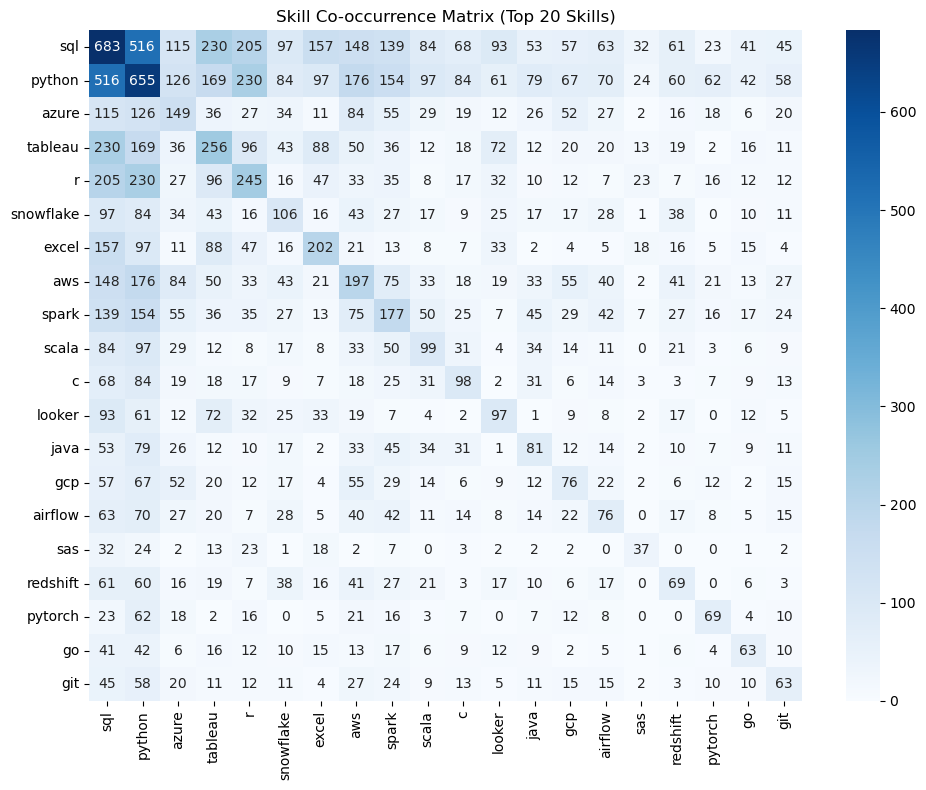

In [131]:
# Skill Co-occurrence Matrix (Top 20 Skills)
import numpy as np

def plot_skill_cooccurrence(df, skill_cols, top_n=20):
    # Merge all skills into one column
    all_skills = df[skill_cols].apply(lambda row: sum(row, []), axis=1)
    # Flatten and get top N
    flat_skills = [skill for sublist in all_skills for skill in sublist if skill]
    from collections import Counter
    top_skills = [s for s, _ in Counter(flat_skills).most_common(top_n)]
    # Create binary matrix
    skill_matrix = np.zeros((len(df), top_n), dtype=int)
    for i, skills in enumerate(all_skills):
        for j, skill in enumerate(top_skills):
            if skill in skills:
                skill_matrix[i, j] = 1
    # Co-occurrence
    co_matrix = np.dot(skill_matrix.T, skill_matrix)
    # Plot heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(co_matrix, xticklabels=top_skills, yticklabels=top_skills, cmap='Blues', annot=True, fmt='d')
    plt.title('Skill Co-occurrence Matrix (Top 20 Skills)')
    plt.tight_layout()
    plt.show()

plot_skill_cooccurrence(df, skill_cols)

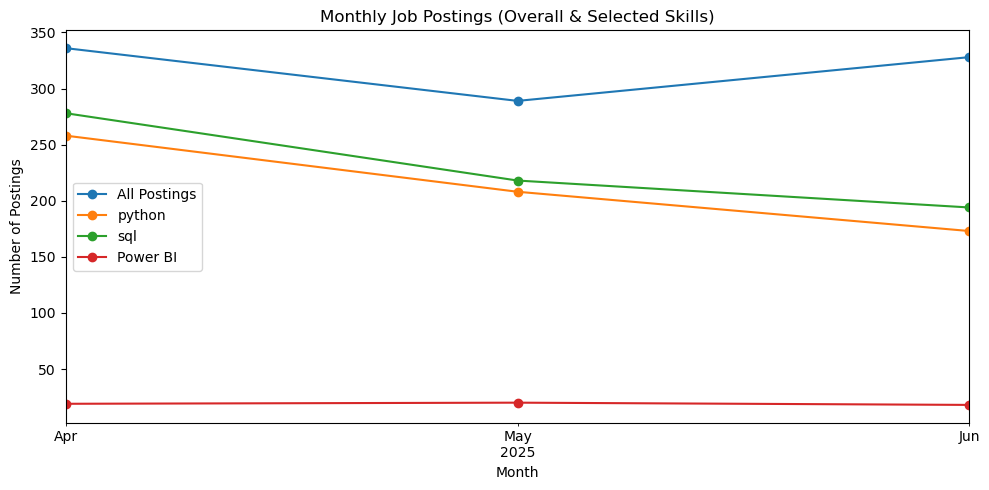

In [132]:
# Temporal Trends: Monthly Job Postings (Overall & Per Skill)
def plot_temporal_trends(df, skill_cols, skill_focus=None):
    # Ensure date_posted is datetime
    df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
    df['month'] = df['date_posted'].dt.to_period('M')
    # Overall trend
    monthly_counts = df.groupby('month').size()
    ax = monthly_counts.plot(kind='line', marker='o', label='All Postings', figsize=(10,5))
    # Per skill (if specified)
    if skill_focus:
        for skill in skill_focus:
            mask = df[skill_cols].apply(lambda row: any(skill in s for s in sum(row, [])), axis=1)
            df_skill = df[mask]
            skill_counts = df_skill.groupby('month').size()
            skill_counts.plot(ax=ax, marker='o', label=skill)
    plt.title('Monthly Job Postings (Overall & Selected Skills)')
    plt.xlabel('Month')
    plt.ylabel('Number of Postings')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: plot for Python, SQL, Power BI
plot_temporal_trends(df, skill_cols, skill_focus=['python', 'sql', 'Power BI'])

---

## Step 5: Clustering & Segmentation

We engineer binary skill features, cluster job postings, and visualize the clusters using UMAP or t-SNE.

In [133]:
# Feature Engineering: Binary Skill Matrix (Top 50 Skills)
from collections import Counter

# Merge all skills into one column per job
all_skills = df[skill_cols].apply(lambda row: sum(row, []), axis=1)
flat_skills = [skill for sublist in all_skills for skill in sublist if skill]
top_n = 50

top_skills = [s for s, _ in Counter(flat_skills).most_common(top_n)]

# Create binary matrix
for skill in top_skills:
    df[f'skill_{skill}'] = all_skills.apply(lambda skills: int(skill in skills))

skill_matrix = df[[f'skill_{skill}' for skill in top_skills]].values
print(f"Binary skill matrix shape: {skill_matrix.shape}")

Binary skill matrix shape: (976, 50)


In [134]:
# Clustering: KMeans on Skill Matrix
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(skill_matrix)
df['cluster'] = clusters
print(f"Assigned {n_clusters} clusters to job postings.")

Assigned 5 clusters to job postings.


In [135]:
#  find out exactly which Python executable your notebook is using:
import sys
print(sys.executable)

C:\Users\AbdulHafeez\anaconda3\envs\myenv\python.exe


In [5]:
# use that specific Python path to install the package.
import sys
!{sys.executable} -m pip install umap-learn

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 16.5 MB/s eta 0:00:00
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----- ---------------------------------- 3.9/30.3 MB 19.5 MB/s eta 0:00:02
   --------- ------------------------------ 7.1/30.3 MB 16.7 MB/s eta 0:00:02
   -------------- ------------------------- 11.3/30.3 MB 18.0 MB/s eta 0:00:02
   --------------------- ------------------ 16.0/30.3 MB 18.6 MB/s eta 0:00:01
   -------------------------- ------------- 20.4/30.3 MB 19.3 MB/s eta 0:00:01
   ------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


C:\Users\AbdulHafeez\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


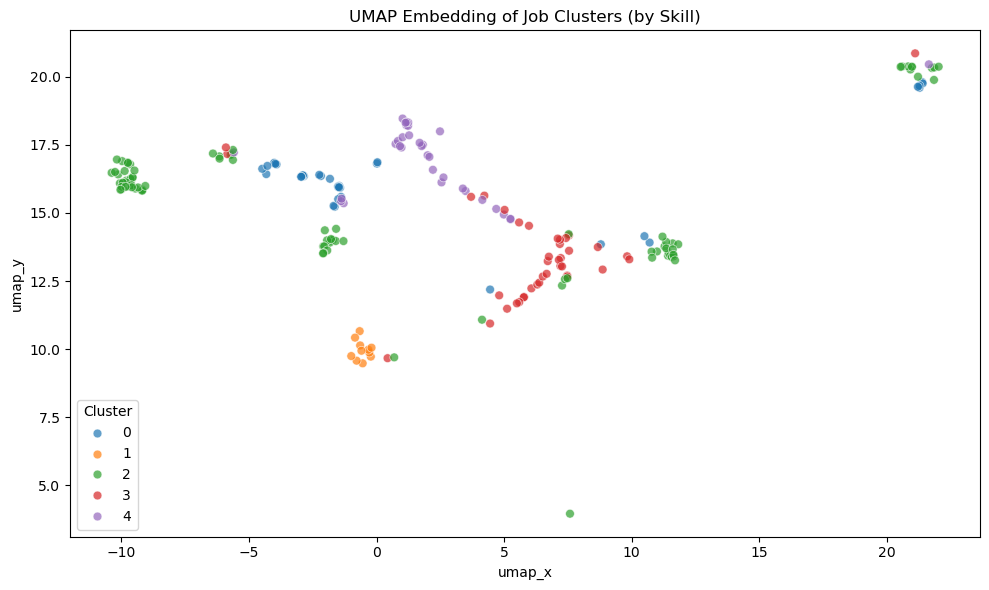

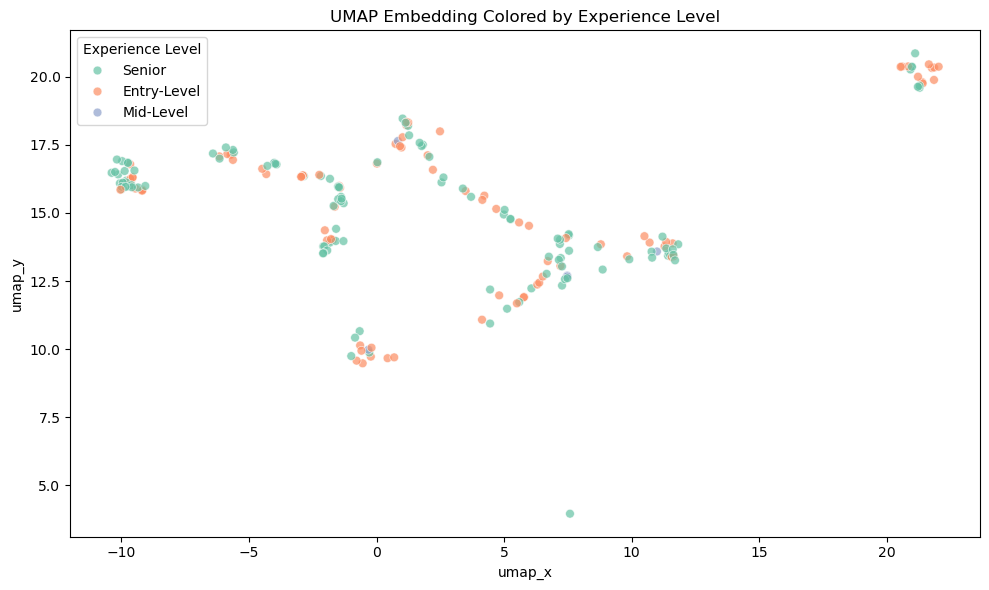

In [136]:
# Visualization: UMAP Embedding of Clusters
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(skill_matrix)
df['umap_x'] = embedding[:,0]
df['umap_y'] = embedding[:,1]

# Remove rows where experience_level is "Not Specified" (case-insensitive)
df_plot = df[~df['experience_level'].str.lower().str.contains('not specified', na=False)]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='cluster',
    palette='tab10',
    data=df_plot, alpha=0.7, s=40
)
plt.title('UMAP Embedding of Job Clusters (by Skill)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Optionally, color by experience level
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='experience_level',
    palette='Set2',
    data=df_plot, alpha=0.7, s=40
)
plt.title('UMAP Embedding Colored by Experience Level')
plt.legend(title='Experience Level')
plt.tight_layout()
plt.show()

### UMAP Embedding of Job Clusters (by Skill)

- **What you see:**  
  Each point represents a job posting, positioned in 2D space so that jobs with similar skill sets are closer together. Points are colored by their assigned cluster (from KMeans).

- **What the clusters mean:**  
  - Each color/cluster groups jobs that require similar combinations of the top 50 skills.
  - If you see tight, well-separated clusters, it means there are distinct “types” of jobs in your dataset, each with a characteristic skill profile.
  - Overlapping or diffuse clusters suggest more blended or less distinct skill requirements across postings.

- **Practical implications:**  
  - You can identify major “job families” (e.g., data engineering, analytics, ML engineering) based on the dominant skills in each cluster.
  - Recruiters or job seekers can target clusters that match their skills or hiring needs.
  - Outliers (points far from clusters) may represent unique or niche roles.

---

### UMAP Embedding Colored by Experience Level

- **What you see:**  
  The same 2D embedding, but now points are colored by experience level (e.g., Entry-Level, Mid-Level, Senior).

- **What the color distribution means:**  
  - If certain regions are dominated by a single experience level, it suggests those skill combinations are more common at that level.
  - If colors are well-mixed, it means similar skill sets are required across multiple experience levels.
  - For example, a cluster with mostly “Senior” roles may indicate advanced or specialized skill requirements.

- **Practical implications:**  
  - Helps understand how skill requirements change (or don’t) with experience.
  - Can reveal if some clusters are accessible to entry-level candidates, or if others are reserved for more senior professionals.
  - Useful for career planning: candidates can see which skill sets to develop to move into higher-level roles.

---

### How to Use These Insights

- **For job seekers:**  
  Identify which cluster(s) your skills fit into, and target those job types. See what skills are common in your desired experience level.
- **For employers:**  
  Understand the competitive landscape for talent, and how your job postings compare to others in terms of skill requirements.
- **For curriculum/career advisors:**  
  Recommend skill development paths that align with in-demand clusters and experience levels.

---

We can further analyze the clusters by:
- Examining the most common skills in each cluster.
- Looking at salary distributions within clusters.
- Exploring how clusters relate to job location or work type.

### Examining the Most Common Skills in Each Cluster

In [137]:
from collections import Counter

# For each cluster, print the top 10 skills
for cluster in sorted(df['cluster'].unique()):
    cluster_skills = df[df['cluster'] == cluster][skill_cols].apply(lambda row: sum(row, []), axis=1)
    flat_skills = [skill for sublist in cluster_skills for skill in sublist if skill]
    top_skills = Counter(flat_skills).most_common(10)
    print(f"Cluster {cluster}:")
    for skill, count in top_skills:
        print(f"  {skill}: {count}")
    print("-" * 30)

Cluster 0:
  excel: 171
  sql: 147
  tableau: 83
  python: 66
  powerpoint: 32
  snowflake: 30
  looker: 26
  sas: 26
  r: 23
  word: 23
------------------------------
Cluster 1:
  python: 63
  tensorflow: 62
  pytorch: 60
  azure: 38
  scikit-learn: 34
  sql: 24
  aws: 23
  pandas: 20
  spark: 19
  r: 18
------------------------------
Cluster 2:
  sql: 229
  python: 227
  r: 95
  azure: 50
  c: 48
  snowflake: 38
  scala: 32
  go: 23
  aws: 23
  sas: 22
------------------------------
Cluster 3:
  azure: 174
  python: 172
  sql: 154
  spark: 117
  aws: 116
  snowflake: 112
  java: 60
  scala: 58
  airflow: 50
  redshift: 47
------------------------------
Cluster 4:
  tableau: 138
  sql: 129
  python: 127
  r: 94
  looker: 55
  snowflake: 32
  azure: 32
  aws: 25
  excel: 23
  sas: 20
------------------------------


From those top‑10 lists, here’s what each cluster looks like in human‑readable form—and what it suggests about the underlying job archetypes:

---

#### Cluster 0: “Business / Reporting Analysts”

* **Dominant skills:** Excel (171), SQL (147), Tableau (83), PowerPoint (32), Word (23)
* **Supporting tools:** Snowflake, Looker, SAS, R, Python
* **Interpretation:**

  * This group is heavily focused on **self‑service BI and reporting**, using Excel + SQL at the core, with visualization layers in Tableau or Looker.
  * Lower counts for Python/R suggest these roles may occasionally script, but are predominantly “no‑/low‑code” analysts.

---

#### Cluster 1: “Machine Learning Engineers / Researchers”

* **Dominant skills:** Python (63), TensorFlow (62), PyTorch (60), scikit‑learn (34)
* **Cloud / infra:** Azure (38), AWS (23), Spark (19)
* **Interpretation:**

  * These jobs are centered on **model development**, with deep‑learning frameworks (TF/PyTorch) at near‑parity with core Python.
  * Moderate cloud usage indicates they’re productionizing or experimenting in cloud environments.

---

#### Cluster 2: “General Data Scientists / Analytics Engineers”

* **Dominant skills:** SQL (229), Python (227), R (95)
* **Additional languages:** C (48), Scala (32), Go (23)
* **Cloud / warehouse:** Azure, Snowflake, AWS, SAS
* **Interpretation:**

  * A broad, **polyglot data‑science role**, splitting time between SQL + Python/R analysis and some lower‑level engineering (C/Scala).
  * Likely these are midsize teams where data scientists also build or maintain data pipelines.

---

#### Cluster 3: “Data Engineers / Big‑Data Specialists”

* **Dominant skills:** Azure (174), Python (172), SQL (154), Spark (117), AWS (116), Snowflake (112)
* **Ecosystem tools:** Java (60), Scala (58), Airflow (50), Redshift (47)
* **Interpretation:**

  * Clearly the **data‑pipeline crowd**—big‑data frameworks (Spark), orchestration (Airflow), poly‑cloud warehouse (Snowflake/Redshift).
  * Java/Scala support “heavy” Spark jobs and integration with enterprise frameworks.

---

#### Cluster 4: “BI / Analytics Developers”

* **Dominant skills:** Tableau (138), SQL (129), Python (127), R (94), Looker (55)
* **Warehouse / cloud:** Snowflake, Azure, AWS
* **Reporting staples:** Excel, SAS
* **Interpretation:**

  * A **hybrid BI/developer role**, writing Python or R for analysis but packaging results in Tableau or Looker.
  * Looks like more “analytic app” builds rather than purely dashboarding in Excel.

---

#### What This Tells Us

1. **Distinct Role Archetypes**

   * We’ve captured at least five clear segments—from pure BI to hardcore ML research to data engineering.
2. **Skill‑Stack Recommendations**

   * If we’re guiding learners:

     * **Cluster 0 →** focus on SQL + Excel + Tableau/Power BI.
     * **Cluster 1 →** go deep on Python + TF/PyTorch + cloud MLOps.
     * **Cluster 3 →** master Spark + Airflow + Java/Scala + Snowflake/Redshift.
3. **Product Implications**

   * Our navigator tool could offer **“career pathways”** tailored to each cluster—e.g. “From Cluster 0 → Cluster 4” via Python courses, or “Cluster 2 → Cluster 1” via deep‑learning bootcamps.
4. **Data‑Collection Gaps**

   * Notice lower counts for GCP or emerging tools (e.g. Docker/Kubernetes). We might want to enhance our extractor to pick up these newer skills if coverage is strategic.

We can utilize these insights to power personalized recommendations, curriculum mappings, or salary benchmarks by archetype.


### Mapping from Cluster Number to Archetype Name

To make our visualizations more insightful and user-friendly, we can map each cluster number to a human-readable archetype name and use these names in our plots and dashboards. Here’s how you can do it:

In [138]:
cluster_names = {
    0: "Business / Reporting Analysts",
    1: "Machine Learning Engineers / Researchers",
    2: "General Data Scientists / Analytics Engineers",
    3: "Data Engineers / Big-Data Specialists",
    4: "BI / Analytics Developers"
}
df['cluster_name'] = df['cluster'].map(cluster_names)

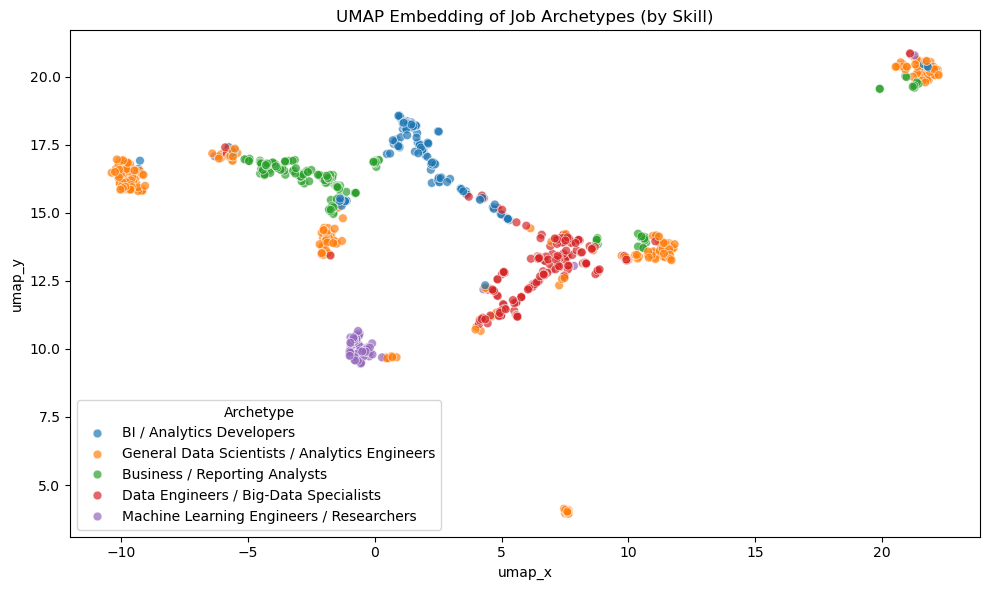

In [139]:
# Visualization: UMAP Embedding of Mapped Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='umap_x', y='umap_y',
    hue='cluster_name',
    palette='tab10',
    data=df, alpha=0.7, s=40
)
plt.title('UMAP Embedding of Job Archetypes (by Skill)')
plt.legend(title='Archetype')
plt.tight_layout()
plt.show()

### Examining the Most Common Skills in Each Archetype

In [140]:
from collections import Counter

# For each archetype, print the top 10 skills (omit missing archetype)
for archetype in df['cluster_name'].dropna().unique():
    cluster_df = df[df['cluster_name'] == archetype]
    # Omit rows with 'Not Specified' in experience_level
    cluster_df = cluster_df[~cluster_df['experience_level'].str.lower().str.contains('not specified', na=False)]
    cluster_skills = cluster_df[skill_cols].apply(lambda row: sum(row, []), axis=1)
    flat_skills = [skill for sublist in cluster_skills for skill in sublist if skill]
    top_skills = Counter(flat_skills).most_common(10)
    print(f"{archetype}:")
    for skill, count in top_skills:
        print(f"  {skill}: {count}")
    print("-" * 30)

BI / Analytics Developers:
  tableau: 32
  sql: 31
  python: 30
  r: 21
  looker: 15
  azure: 12
  sas: 8
  snowflake: 6
  excel: 6
  aws: 5
------------------------------
General Data Scientists / Analytics Engineers:
  python: 41
  sql: 40
  azure: 26
  r: 15
  c: 11
  go: 8
  aws: 7
  jira: 6
  scala: 6
  docker: 6
------------------------------
Business / Reporting Analysts:
  excel: 33
  sql: 28
  tableau: 12
  python: 11
  looker: 8
  r: 6
  powerpoint: 6
  word: 5
  Power BI: 4
  outlook: 4
------------------------------
Data Engineers / Big-Data Specialists:
  azure: 50
  python: 40
  snowflake: 30
  aws: 30
  sql: 27
  spark: 19
  java: 18
  gcp: 15
  scala: 14
  mysql: 12
------------------------------
Machine Learning Engineers / Researchers:
  python: 11
  tensorflow: 11
  pytorch: 9
  scikit-learn: 7
  azure: 6
  r: 5
  keras: 4
  numpy: 4
  pandas: 4
  gcp: 4
------------------------------


### Salary Distributions Within Archetypes

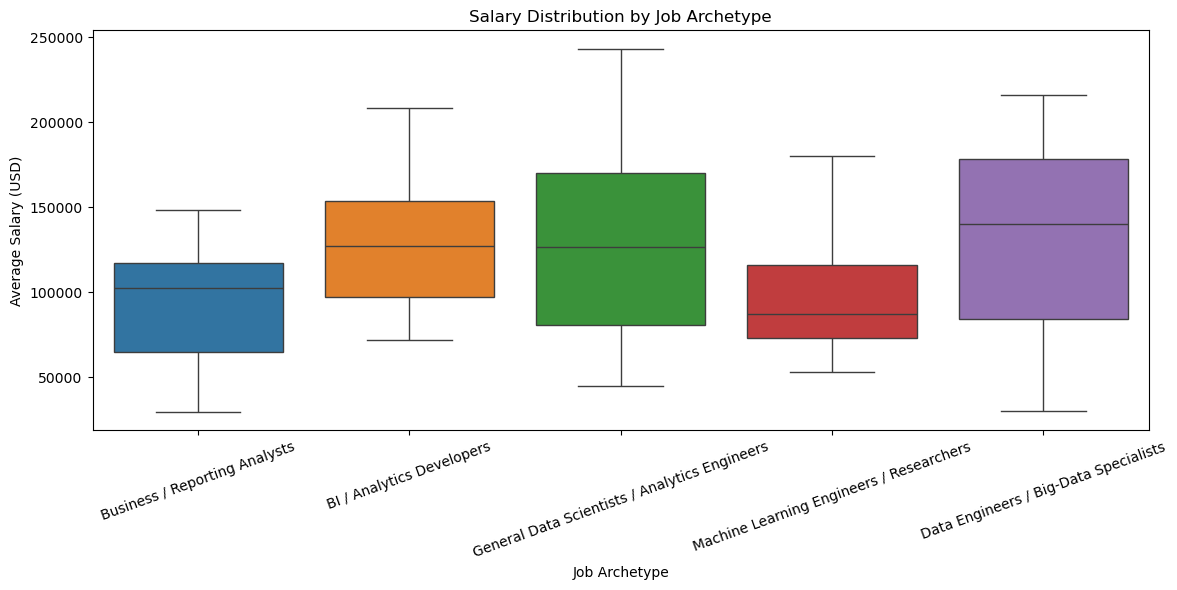

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(
    x='cluster_name',
    y='avg_salary',
    hue='cluster_name',
    data=df[
        df['avg_salary'].notnull() &
        df['cluster_name'].notnull() &
        ~df['experience_level'].str.lower().str.contains('not specified', na=False)
    ],
    palette='tab10'
)
plt.title('Salary Distribution by Job Archetype')
plt.xlabel('Job Archetype')
plt.ylabel('Average Salary (USD)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

### Archetypes by Job Location or Work Type

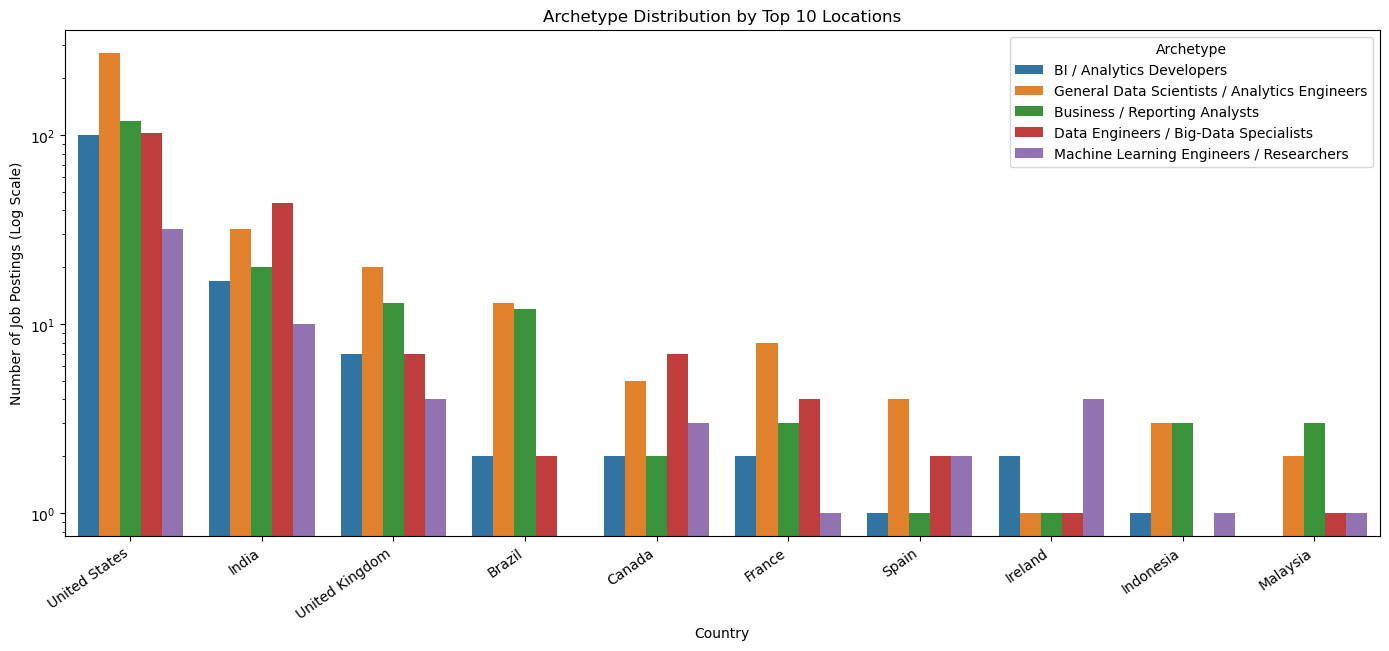

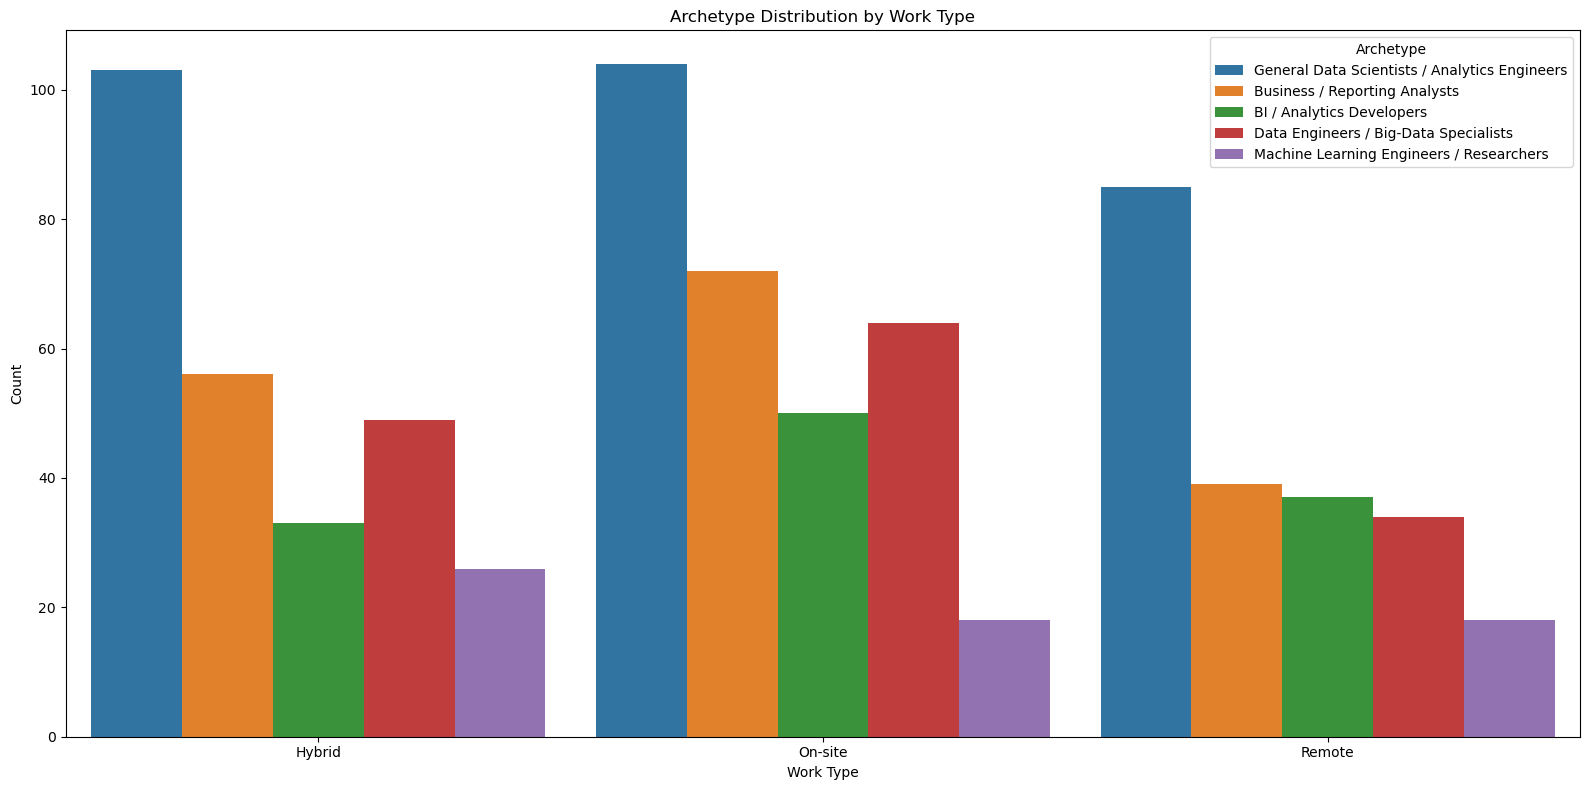

In [142]:
# By location
# By location
plt.figure(figsize=(14,6))
top_countries = df[df['country'].notnull()]['country'].value_counts().head(10).index

filtered_data = df[
    df['country'].isin(top_countries) &
    df['cluster_name'].notnull()
]

# Create the plot and store the Axes object in 'ax'
ax = sns.countplot(
    x='country',
    hue='cluster_name',
    data=filtered_data,
    palette='tab10',
    order=top_countries
)

# Set log scale on y axis
ax.set_yscale('log')

plt.title('Archetype Distribution by Top 10 Locations')
plt.xlabel('Country')
plt.ylabel('Number of Job Postings (Log Scale)')
plt.legend(title='Archetype')
plt.tight_layout()
# Use plt.setp for label rotation and formatting
plt.setp(ax.get_xticklabels(), rotation=35, ha='right', fontsize=10)
plt.show()

# By work type (omit 'Not Specified')
plt.figure(figsize=(16,8))  # Increase width from 10 to 14 (or higher if needed)
sns.countplot(
    x='work_type',
    hue='cluster_name',
    data=df[
        df['cluster_name'].notnull() &
        ~df['work_type'].str.lower().str.contains('not specified', na=False)
    ],
    palette='tab10',
    width=0.9  # Wider bars
)
plt.title('Archetype Distribution by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.legend(title='Archetype')
plt.tight_layout()
plt.show()

---

## Step 6: Geographic & Work-Type Analysis

We parse job locations, analyze salary and skill demand by geography, and compare across work types.

### 1. Salary and Skill Demand by Country (Top 10 Countries)

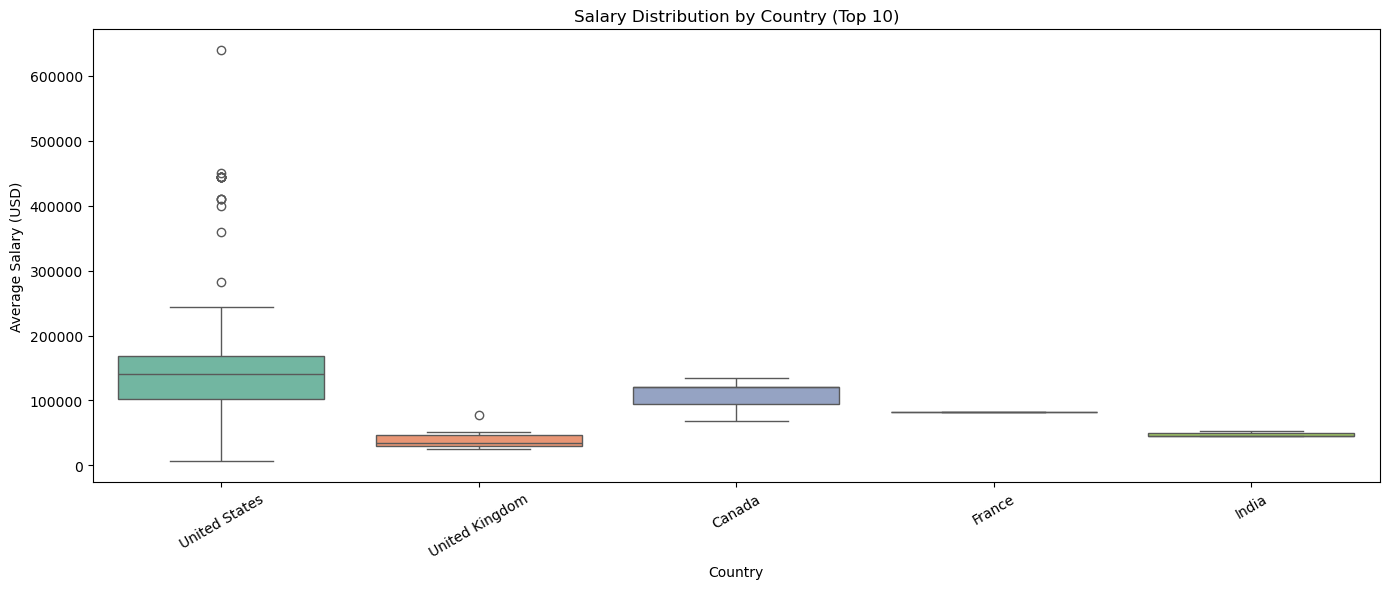

United States: [('sql', 440), ('python', 431), ('r', 170), ('tableau', 166), ('azure', 156)]
India: [('sql', 99), ('python', 90), ('azure', 70), ('snowflake', 54), ('aws', 46)]
United Kingdom: [('sql', 32), ('python', 26), ('azure', 18), ('tableau', 14), ('r', 12)]
Brazil: [('sql', 23), ('python', 14), ('excel', 12), ('azure', 10), ('r', 10)]
Canada: [('python', 15), ('sql', 13), ('azure', 10), ('spark', 6), ('mysql', 4)]
France: [('python', 11), ('c', 9), ('sql', 7), ('sas', 6), ('aws', 5)]
Spain: [('python', 7), ('r', 4), ('sql', 4), ('tableau', 3), ('scikit-learn', 3)]
Ireland: [('python', 8), ('sql', 5), ('tableau', 4), ('pytorch', 4), ('tensorflow', 4)]
Indonesia: [('sql', 4), ('excel', 3), ('python', 3), ('r', 3), ('sas', 2)]
Malaysia: [('sql', 6), ('python', 4), ('excel', 3), ('looker', 3), ('nosql', 2)]


In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Salary by country (top 10)
plt.figure(figsize=(14,6))
top_countries = df['country'].value_counts().head(10).index
sns.boxplot(
    x='country',
    y='avg_salary',
    hue='country',
    legend=False,
    data=df[df['country'].isin(top_countries) & df['avg_salary'].notnull()],
    palette='Set2'
)
plt.title('Salary Distribution by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Average Salary (USD)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Skill demand by country (top 5 skills)
for country in top_countries:
    skills = df[df['country'] == country][skill_cols].apply(lambda row: sum(row, []), axis=1)
    flat_skills = [skill for sublist in skills for skill in sublist if skill]
    top_skills = Counter(flat_skills).most_common(5)
    print(f"{country}: {top_skills}")

### 2. Salary and Skill Demand by Work Type (Remote, Onsite, Hybrid)

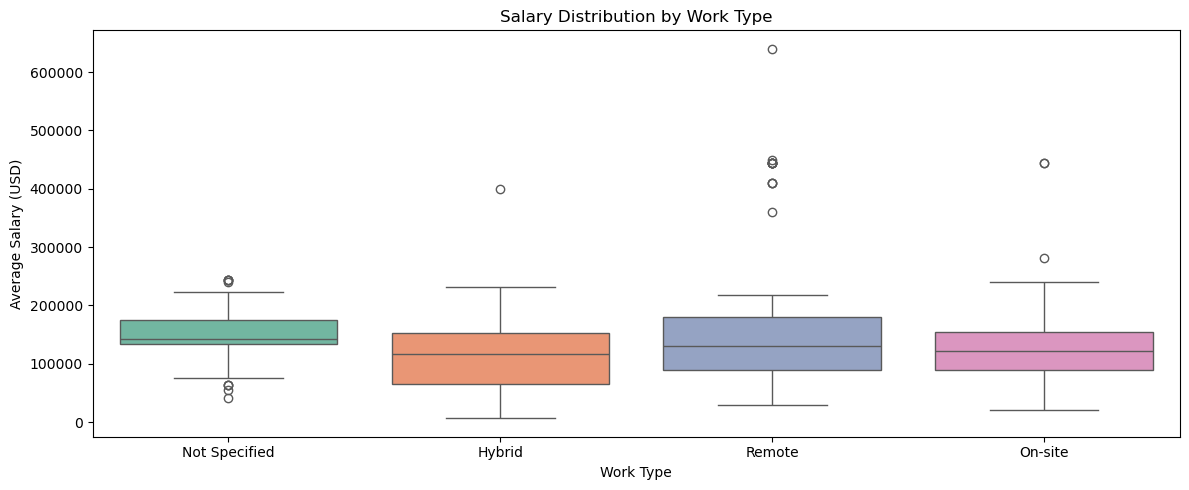

Not Specified: [('sql', 144), ('python', 131), ('r', 61), ('azure', 42), ('aws', 41)]
Hybrid: [('sql', 187), ('python', 180), ('azure', 80), ('tableau', 67), ('r', 64)]
On-site: [('sql', 219), ('python', 210), ('azure', 112), ('tableau', 92), ('excel', 77)]
Remote: [('python', 134), ('sql', 133), ('azure', 64), ('tableau', 59), ('snowflake', 56)]


In [144]:
plt.figure(figsize=(12,5))
sns.boxplot(
    x='work_type',
    y='avg_salary',
    hue='work_type',
    legend=False,
    data=df[df['avg_salary'].notnull() & df['work_type'].notnull()],
    palette='Set2'
)
plt.title('Salary Distribution by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Average Salary (USD)')
plt.tight_layout()
plt.show()

# Skill demand by work type (top 5 skills)
for wt in df['work_type'].dropna().unique():
    skills = df[df['work_type'] == wt][skill_cols].apply(lambda row: sum(row, []), axis=1)
    flat_skills = [skill for sublist in skills for skill in sublist if skill]
    top_skills = Counter(flat_skills).most_common(5)
    print(f"{wt}: {top_skills}")

---

## Step 7: Dashboard & Reporting

We create aggregate tables and summary visualizations to support reporting and dashboarding for skill demand, salary percentiles, and more.

In [145]:
# Aggregate Table: Skill Demand by Experience Level and Country
from collections import Counter

agg = []
for exp in df['experience_level'].dropna().unique():
    for country in df['country'].dropna().unique():
        subset = df[(df['experience_level'] == exp) & (df['country'] == country)]
        skills = subset[skill_cols].apply(lambda row: sum(row, []), axis=1)
        flat_skills = [skill for sublist in skills for skill in sublist if skill]
        top_skills = Counter(flat_skills).most_common(3)
        agg.append({
            'experience_level': exp,
            'country': country,
            'top_skills': top_skills
        })
import pandas as pd
agg_df = pd.DataFrame(agg)
agg_df.head(10)

,experience_level,country,top_skills
0,Not Specified,United States,"[(sql, 366), (python, 346), (r, 139)]"
1,Not Specified,Brazil,"[(sql, 15), (python, 8), (excel, 7)]"
2,Not Specified,India,"[(sql, 85), (python, 75), (azure, 52)]"
3,Not Specified,United Kingdom,"[(sql, 27), (python, 23), (azure, 18)]"
4,Not Specified,Bulgaria,"[(sql, 1), (git, 1), (tableau, 1)]"
5,Not Specified,Indonesia,"[(excel, 3), (sql, 2), (python, 2)]"
6,Not Specified,Saudi Arabia,"[(excel, 1)]"
7,Not Specified,Canada,"[(python, 13), (sql, 11), (spark, 6)]"
8,Not Specified,Spain,"[(python, 4), (tableau, 3), (r, 3)]"
9,Not Specified,Singapore,"[(python, 2), (sql, 2), (vba, 1)]"


In [146]:
# Salary Percentiles by Skill (Top 20 Skills)
skill_salary = []
from numpy import percentile
all_skills = df[skill_cols].apply(lambda row: sum(row, []), axis=1)
flat_skills = [skill for sublist in all_skills for skill in sublist if skill]
top_skills = [s for s, _ in Counter(flat_skills).most_common(20)]
for skill in top_skills:
    mask = all_skills.apply(lambda skills: skill in skills)
    salaries = df.loc[mask, 'avg_salary'].dropna()
    if len(salaries) > 0:
        skill_salary.append({
            'skill': skill,
            'p25': percentile(salaries, 25),
            'median': percentile(salaries, 50),
            'p75': percentile(salaries, 75),
            'count': len(salaries)
        })
skill_salary_df = pd.DataFrame(skill_salary)
skill_salary_df.sort_values('median', ascending=False).head(10)

,skill,p25,median,p75,count
17,pytorch,133125.0,152000.0,228750.0,22
8,spark,119550.0,149750.0,174500.0,78
12,java,112661.5,149500.0,175500.0,38
9,scala,141000.0,145150.0,189200.0,59
14,airflow,121500.0,145000.0,175500.0,37
10,c,138447.5,142750.0,173375.0,52
1,python,106625.0,142500.0,170000.0,291
4,r,107500.0,142500.0,164500.0,105
13,gcp,104962.5,140775.0,171375.0,24
16,redshift,118900.0,140000.0,162250.0,33


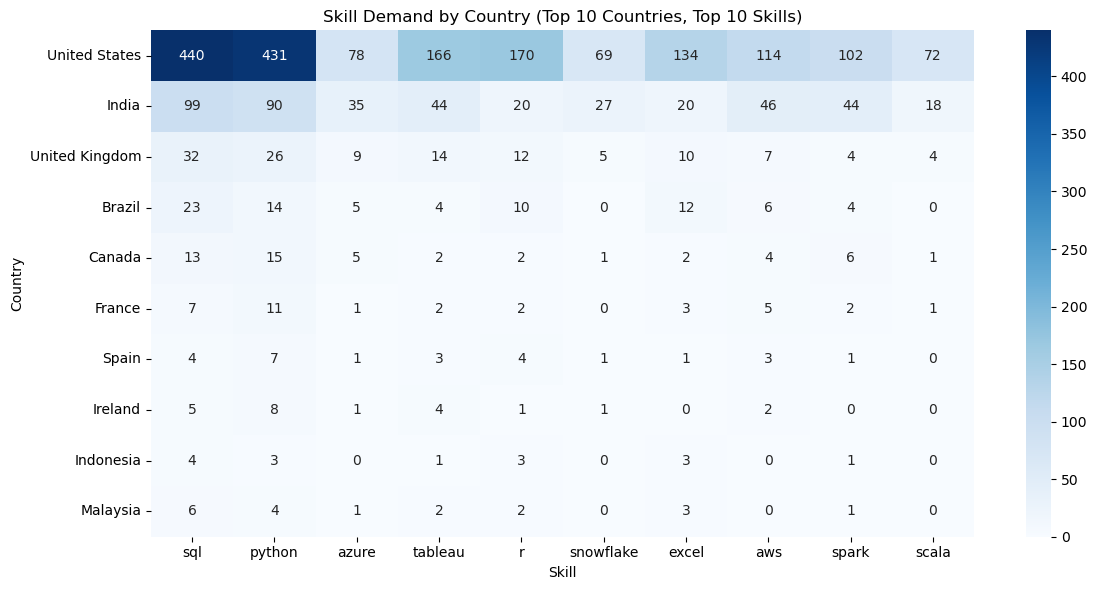

In [147]:
# Heatmap: Skill Demand by Country (Top 10 Countries, Top 10 Skills)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
country_counts = df['country'].value_counts().head(10).index
all_skills = df[skill_cols].apply(lambda row: sum(row, []), axis=1)
flat_skills = [skill for sublist in all_skills for skill in sublist if skill]
skill_counts = Counter(flat_skills)
top_skills = [s for s, _ in skill_counts.most_common(10)]

heatmap_data = np.zeros((len(country_counts), len(top_skills)), dtype=int)
for i, country in enumerate(country_counts):
    for j, skill in enumerate(top_skills):
        mask = (df['country'] == country) & all_skills.apply(lambda skills: skill in skills)
        heatmap_data[i, j] = mask.sum()

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_skills, yticklabels=country_counts)
plt.title('Skill Demand by Country (Top 10 Countries, Top 10 Skills)')
plt.xlabel('Skill')
plt.ylabel('Country')
plt.tight_layout()
plt.show()